In [44]:
import torch 
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [148]:
# df = pd.read_csv('C:/Users/louis/github_vs/archive/Submission.csv')
df = pd.read_csv('C:/Users/louis/github_vs/archive/fer2013/fer2013/fer2013.csv')
train = df[df["Usage"]=="Training"]
train_y = train['emotion'].reset_index(drop=True)
train_x = train['pixels'].apply( lambda x : np.array(x.split(" ")).astype('float')/255)

test = df[df["Usage"]=="PublicTest"]
test_y = test['emotion'].reset_index(drop=True)
test_x = test['pixels'].apply( lambda x : np.array(x.split(" ")).astype('float')/255)

validation = df[df["Usage"]=="PrivateTest"]
validation_y = validation['emotion'].reset_index(drop=True)
validation_x = validation['pixels'].apply( lambda x : np.array(x.split(" ")).astype('float')/255)

batch_size = 16
trainloader = torch.utils.data.DataLoader(train_x, shuffle = False,batch_size = batch_size)
valloader = torch.utils.data.DataLoader(validation_x, shuffle = False,batch_size = batch_size)
testloader = torch.utils.data.DataLoader(test_x, shuffle = False,batch_size = batch_size)

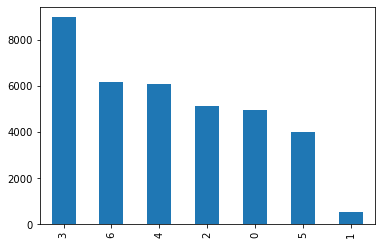

In [112]:
df['emotion'].value_counts().plot(kind = "bar")

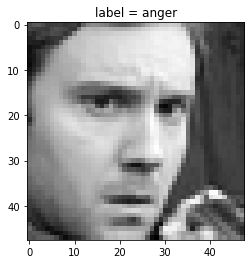

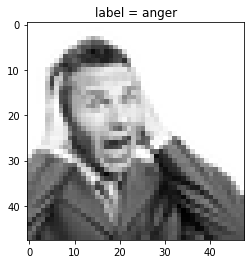

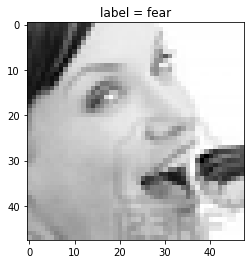

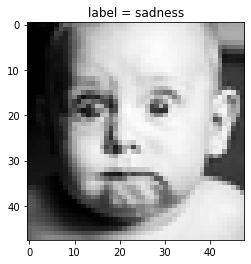

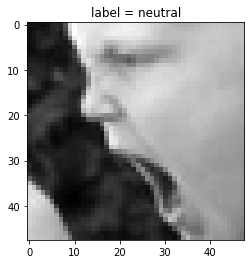

In [151]:
class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

it = iter(trainloader)

for i in range(5):
    out = it.next()
    plt.figure()
    plt.imshow(out[i].reshape(48,48),cmap='gray')
    plt.title("label = "+class_names[train_y[i]])

In [152]:
in_size = 2304
out_size = 4
h_size = 32

model = nn.Sequential(nn.Linear(in_size, h_size),
   nn.ReLU(),
   nn.Linear(h_size, out_size),
   nn.Sigmoid())

# source: https://tomroth.com.au/pytorch-cnn/
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
printfreq=1000
for epoch in range(2):
    for i, data in enumerate(trainloader):
            inputs=data
            labels = train_y.get([i*batch_size,i*(batch_size+1)])
            optimizer.zero_grad()
            outputs = model(inputs)  # forward pass 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % printfreq == printfreq-1:  
                print(epoch, i+1, running_loss / printfreq)
                running_loss = 0

RuntimeError: expected scalar type Float but found Double